# مدل ترش‌هولد برای سهام مایکروسافت

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from bds import bds

import warnings
warnings.filterwarnings('ignore')

ابتدا فایل اطلاعات قیمتی را که در تمرین اول دریافت کردیم، می‌خوانیم: 

In [2]:
df_msft = pd.read_excel('./excel_files/01_NYSE_prices.xlsx', sheet_name='MSFT')

In [3]:
df_msft[['Date', 'Adj Close']]

,Date,Adj Close
0,2017-01-03,57.807819
1,2017-01-04,57.549183
2,2017-01-05,57.549183
3,2017-01-06,58.047997
4,2017-01-09,57.863251
...,...,...
1452,2022-10-10,229.250000
1453,2022-10-11,225.410004
1454,2022-10-12,225.750000
1455,2022-10-13,234.240005


## آماده‌سازی داده

سری زمانی قیمت‌های تعدیل شده را می‌سازیم:

In [4]:
prices_series = df_msft.set_index('Date')['Adj Close']

برای گپ‌های موجود به ترتیب این کارها را می‌کنیم:

1. فرکانس سری زمانی را روزانه می‌کنیم.
  
2. با متد ffill مقادیر نال به وجود آمده را پر می‌کنیم.
  
3. چون برای همه شنبه‌ها و یکشنبه‌ها، دیتایی در دسترس نبوده، بنابراین این دو روز را از سری زمانی حذف می‌کنیم.

In [5]:
prices_series = prices_series['2018':].asfreq('1D').ffill()
prices_series = prices_series[prices_series.index.weekday<5]

نگاهی به سری زمانی می‌اندازیم. این سری ناماناست.

<AxesSubplot:title={'center':'MSFT Adj Close'}, xlabel='Date'>

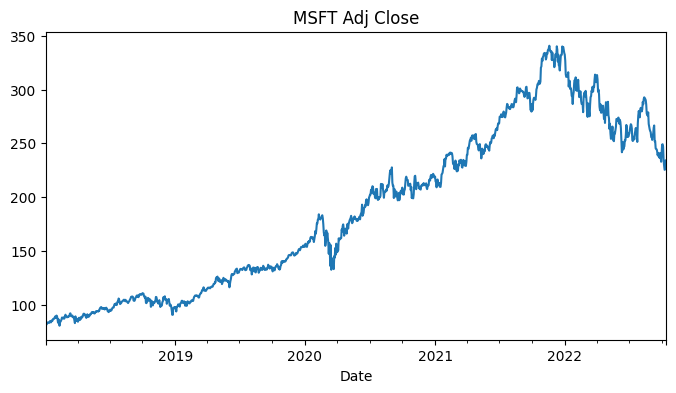

In [6]:
prices_series.plot(title='MSFT Adj Close', figsize=(8, 4))

از سری دیفرنس می‌گیریم و نمودار آن را رسم می‌کنیم. به نظر می‌رسد با یک بار دیفرنس گرفتن، سری مانا شده است.

<AxesSubplot:title={'center':'MSFT Diff Adj Close'}, xlabel='Date'>

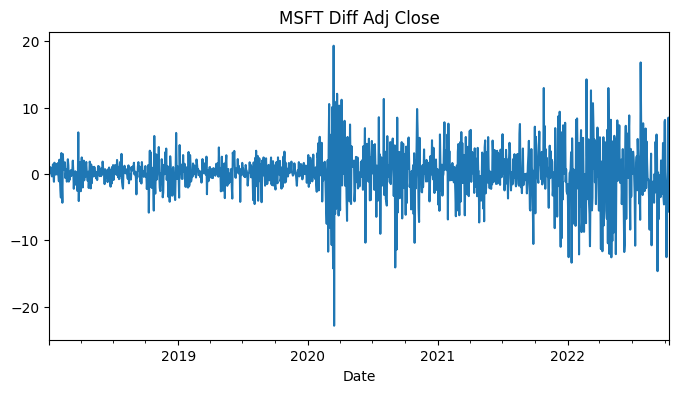

In [7]:
diff_prices = prices_series.diff()
diff_prices = diff_prices['2018':]
diff_prices.plot(title='MSFT Diff Adj Close', figsize=(8, 4))

تست ADF را برای مانایی اجرا می‌کنیم. خروجی دوم، مقدار p-value را برای این تست نمایش نمی‌دهد. سری ماناست..

In [8]:
adfuller(diff_prices.reset_index()['Adj Close'].dropna())

(-10.606369034110845,
 5.98823668149399e-19,
 12,
 1235,
 {'1%': -3.4356560275160835,
  '5%': -2.8638831211270817,
  '10%': -2.568017509711682},
 6654.980126159714)

بنابراین مقدار d در مدل ARIMA برابر با یک است.

حال مدل $ARIMA(p, 1, 0)$ را برای سری زمانی به کار می‌گیریم.

## مدل‌ AR
اگر بتونیم سری را با مدل AR مدل کنیم و مانده‌های مدل نیز i.i.d باشند، می‌توان نتیجه گرفت که سری رفتار غیرخطی ندارد.

بنابراین ابتدا باید مطمئن شویم که مانده‌های مدل AR یک سری i.i.d نیست.

تابع pacf سری را نمایش می‌دهیم:

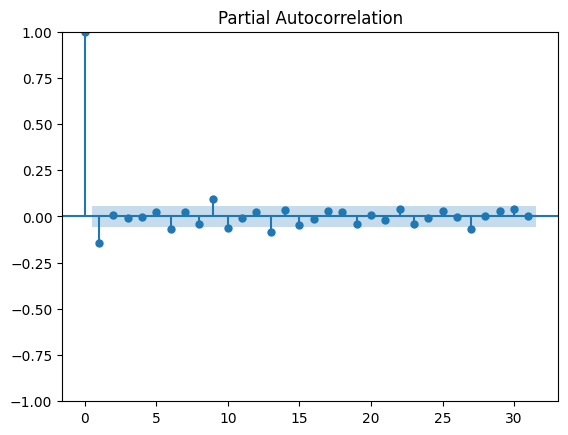

In [9]:
plot_pacf(diff_prices.reset_index()['Adj Close'].dropna())
pyplot.show()

برای پیدا کردن بهترین مرتبه مدل AR این تابع را می‌نویسیم:

In [175]:
def auto_ar_model(values, max_p=12):
    best_orders = None
    _best_aic = np.Inf
    for p in range(1, max_p+1):
        model = ARIMA(values, order=(p,1,0))
        results = model.fit()
        if results.aic < _best_aic:
            _best_aic = results.aic
            best_orders = model.order
    return best_orders

به کمک تابع بالا، بهترین مرتبه مدل AR را به دست می‌اوریم. به نظر می‌رسید مدل AR(10) بهترین مدل از نظر معیار AIC است.

In [176]:
best_order = auto_ar_model(prices_series)
best_order

(10, 1, 0)

مدل‌سازی را به کمک بهترین مرتبه انجام می‌دهیم:

In [177]:
model = ARIMA(prices_series, order=best_order)
results = model.fit()

نتایج مدل AR(10) در زیر به طور خلاصه آورده شده است.

ضرایب لگ‌های اول، ششم، هشتم و دهم معنادارند.

In [178]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 1249
Model:                ARIMA(10, 1, 0)   Log Likelihood               -3373.685
Date:                Sat, 22 Oct 2022   AIC                           6769.370
Time:                        07:28:09   BIC                           6825.793
Sample:                    01-02-2018   HQIC                          6790.583
                         - 10-14-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1283      0.019     -6.691      0.000      -0.166      -0.091
ar.L2          0.0029      0.020      0.144      0.886      -0.037       0.043
ar.L3         -0.0010      0.021     -0.049      0.961      -0.042       0.039
ar.L4         -0.0026      0.021     -0.123      0.902      -0.044       0.038
ar.L5          0.0135      0.021      0.651      0.515      -0.027       0.054
ar.L6         -0.0619      0.021     -3.017      0.003      -0.102      -0.022
ar.L7          0.0196      0.022      0.893      0.372      -0.023       0.063
ar.L8         -0.0249      0.024     -1.050      0.294      -0.071       0.022
ar.L9          0.0912      0.022      4.198      0.000       0.049       0.134
ar.L10        -0.0608      0.020     -2.973      0.003      -0.101      -0.021
sigma2        13.0463      0.329     39.666      0.000      12.402      13.691
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               667.26
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.70   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

نمودار مانده را می‌کشیم:

<AxesSubplot:xlabel='Date'>

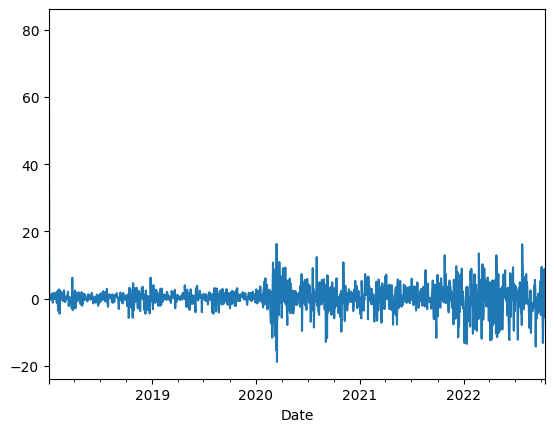

In [179]:
results.resid.plot()

تست BDS را برای i.i.d بودن مانده اجرا می‌کنیم. فرض صفر این تست، i.i.d بودن فرایند است. مقادیر p-value بسیار کوچک‌اند و بنابراین می‌توانیم فرض صفر را رد کنیم. این موضوع موجب می‌شود که بتوانیم امکان روابط غیرخطی در فرایند را بررسی کنیم:

In [180]:
bds(results.resid, 3)

(array([ 8.25708749, 11.01820157]), array([1.49270010e-16, 3.12234912e-28]))

## مدل TAR

مدل TAR در هیچ پکیج پایتونی پیاده‌سازی نشده است.
بنابراین باید این کار را شخصا انجام دهیم.

تابع زیر یک سری زمانی را به همراه لیستی از ترش‌هولدها به عنوان ورودی دریافت می‌کند و برای همه مقادیر ممکن، مدل‌سازی را انجام می‌دهد. سپس MSE هر مدل را در فایل
03_TAR_MSE_LOG.txt
می‌نویسد تا بعدا مورد استفاده قرار بگیرند:

این تابع به این طریق کار می‌کند:

1. ابتدا مقادیر AR(p) را برای به ازای‌ مرتبه‌های مختلف برای سری زمانی ذخیره می‌کند.

2. سپس به ازای همه AR های ممکن در همه ترش‌هولدها خطای MSE را حساب می‌کند و در فایل لاگ ذخیره می‌کند.

برای مثال هنگامی که بیشینه مرتبه مدل AR را پنج انتخاب می‌کنیم و می‌خواهیم مدل‌مان دو ترش‌هولد (سه بخشی) داشته باشد، این تابع مقدار پنج به توان سه یا همان ۱۲۵ خطا را محاسبه می‌کند و در فایل لاگ می‌نویسد.

In [141]:
import itertools

def switching_treshold_model(data, tresholds, max_p=5):
    data = pd.DataFrame(data)
    col_name = data.columns[0]

    # caluclate AR(p) model
    for p in range(1, max_p+1):
        model = ARIMA(data[col_name], order=(p, 1, 0))
        results = model.fit()
        data[f'ar_{p}'] = results.predict()

    
    iterate_matrix = []
    for d in range(len(tresholds)+1):
        iterate_matrix = iterate_matrix.__add__([range(1, max_p+1)])

    f = open('03_TAR_MSE_LOG.txt', 'a')

    for orders in itertools.product(*iterate_matrix):
        switching_pred = data.loc[data[col_name].diff().shift(1) <= tresholds[0], f'ar_{orders[0]}']
        for i in range(len(tresholds)):
            lower_band = tresholds[i]
            upper_band = tresholds[i+1] if len(tresholds)>i+1 else np.Inf
            ar_tmp = data.loc[(data[col_name].diff().shift(1) > lower_band) & (data[col_name].diff().shift(1) <= upper_band), f'ar_{orders[i+1]}']
            switching_pred = switching_pred.append(ar_tmp).sort_index()
        
        err = mean_squared_error(data[col_name][2:], switching_pred)
        f.write(f'{orders} = {err}\n')
    f.close()

تابع بالا را برای دو ترش‌هولد ران می‌کنیم:

1. ترش‌هولد برابر با صفر: زمانی که در روز معاملاتی قبل، بازده مثبت یا منفی بوده

2. ترش‌هولد دوتایی: زمانی که بازده نزدیک صفر بوده یا با آن فاصله مثبت/منفی داشته است.

In [150]:
switching_treshold_model(prices_series, tresholds=[0])
switching_treshold_model(prices_series, tresholds=[-1.8, 1.8])

لاگ را می‌خوانیم و مدلی که کم‌ترین MSE داشته را به عنوان مدل نهایی انتخاب می‌کنیم:

In [151]:
with open('03_TAR_MSE_LOG.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

tar_orders_mse = [[x.split(' = ')[0], x.split(' = ')[1]] for x in lines]
least_mse = np.Inf
for i, elem in enumerate(tar_orders_mse):
    if float(elem[-1]) < least_mse:
        best_mse_index = i
        least_mse = float(elem[-1])

In [152]:
tar_orders_mse[best_mse_index][0]

'(3, 5, 5)'

با اینکه مدل ۲ ترش‌هولد دارد (سه بخشی است) اما بخش دوم و سوم یک مدل مشترک را نمایش می‌دهند: AR(5)

بنابراین مدل نهایی دو بخشی خواهد بود. مقدار ترش‌هولد $-1.8$ و به ترتیب مدل‌های AR(3) و AR(5) برای این دو بخش مناسب خواهند بود.

In [154]:
model3 = ARIMA(prices_series, order=(3, 1, 0))
results3 = model3.fit()

model5 = ARIMA(prices_series, order=(5, 1, 0))
results5 = model5.fit()

price_tar_df = pd.DataFrame(prices_series)
price_tar_df['ar_5_pred'] = results5.predict()
price_tar_df['ar_3_pred'] = results3.predict()

price_tar_df.loc[price_tar_df['Adj Close'].shift(1) <= -1.8, f'switching_pred'] = price_tar_df['ar_3_pred']
price_tar_df.loc[price_tar_df['Adj Close'].shift(1) > -1.8, f'switching_pred'] = price_tar_df['ar_5_pred']

نمودار قیمتی تعادلی را به همراه مدل ترش‌هولد می‌کشیم. به نظر می‌رسد که مدل ترش‌هولد مقادیر قبلی سری زمانی را با کمی تغییر کپی می‌کند.

<AxesSubplot:xlabel='Date'>

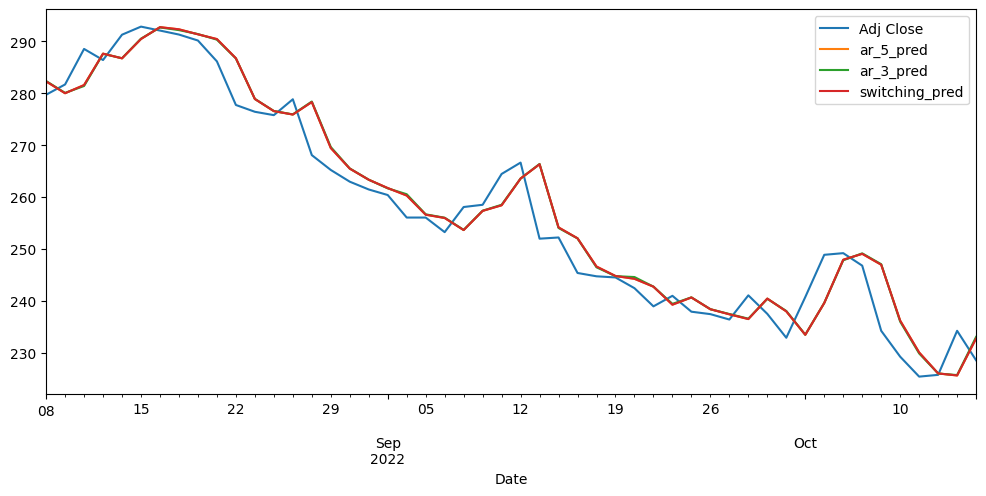

In [160]:
price_tar_df[-50:].plot(figsize=(12, 5))

اما با با محسابه MSE مدل پیش‌بینی naive و مدل TAR می‌بینیم که خطای مدل TAR کم‌تر است.

In [173]:
naive_err = mean_squared_error(prices_series.shift(1).dropna(), prices_series[1:])
tar_err = tar_orders_mse[best_mse_index][-1]
print(f'naive_err: {naive_err} \ntar_err: {tar_err}')

naive_err: 13.604104238513091 
tar_err: 13.313053868375595


دیتافریم پیش‌بینی نهایی:

In [163]:
price_tar_df

,Adj Close,ar_5_pred,ar_3_pred,switching_pred
Date,,,,
2018-01-02,81.168495,0.000000,0.000000,NaN
2018-01-03,81.546249,81.168336,81.168336,81.168336
2018-01-04,82.263962,81.491968,81.491956,81.491968
2018-01-05,83.283882,82.165426,82.165412,82.165426
2018-01-08,83.368858,83.141919,83.141928,83.141919
...,...,...,...,...
2022-10-10,229.250000,236.199686,236.002770,236.199686
2022-10-11,225.410004,230.063678,229.871841,230.063678
2022-10-12,225.750000,226.020748,226.011630,226.020748
